# Local and Central DP with Fed-BioMed: MONAI 2d image registration

## Introduction

This tutorial shows how to deploy in Fed-BioMed the 2d image registration example provided in the project MONAI (https://monai.io/), trained with Differential Privacy (DP). We are going to compare results of:
* non private training
* train with Local Differential Privacy (LDP)
* train with Central Differential Privacy (CDP)

In order to enforce differential privacy during training (both local and central) we will rely on the Opcaus library (https://opacus.ai/). 

## Image Registration

Image registration is the process of transforming and recalibrating different images into one coordinate system. It makes possible to compare several images captured with the same modality.

In this tutorial, we are using a UNet-like registration network ( https://arxiv.org/abs/1711.01666 ).
Goal of the notebook is to train a model given moving images and fixed images (recalibrated images). 

## Start the network
Before running this notebook, start the network with `./scripts/fedbiomed_run network`

## Creating MedNIST nodes

MedNIST provides an artificial 2d classification dataset created by gathering different medical imaging datasets from TCIA, the RSNA Bone Age Challenge, and the NIH Chest X-ray dataset. The dataset is kindly made available by Dr. Bradley J. Erickson M.D., Ph.D. (Department of Radiology, Mayo Clinic) under the Creative Commons CC BY-SA 4.0 license.

To proceed with the tutorial, we created an iid partitioning of the MedNIST dataset between 3 clients. Each client has 3000 image samples for each class. The training partitions are availables at the following link:

https://drive.google.com/file/d/1vLIcBdtdAhh6K-vrgCFy_0Y55dxOWZwf/view

The dataset owned by each client has structure:


└── client_*/

    ├── AbdomenCT/
    
    └── BreastMRI/
    
    └── CXR/
    
    └── ChestCT/
    
    └── Hand/
    
    └── HeadCT/   

To create the federated dataset, we follow the standard procedure for node creation/population of Fed-BioMed. 
After activating the fedbiomed network with the commands

`source ./scripts/fedbiomed_environment network`

and 

`./scripts/fedbiomed_run network`

we create a first node by using the commands

`source ./scripts/fedbiomed_environment node`

`./scripts/fedbiomed_run node start`

We then poulate the node with the data of first client:

`./scripts/fedbiomed_run node add`

We select option 3 (images) to add MedNIST partition of client 1, by just picking the folder of client 1. 
Assign tag `mednist` to the data when asked.

We can further check that the data has been added by executing `./scripts/fedbiomed_run node list`

Following the same procedure, we create the other two nodes with the datasets of client 2 and client 3 respectively.


## Running Fed-BioMed Researcher

We are now ready to start the reseracher enviroment with the command `source ./scripts/fedbiomed_environment researcher`, and open the Jupyter notebook. 

We can first quesry the network for the mednist dataset. In this case, the nodes are sharing the respective partitions unsing the same tag `mednist`:

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fedbiomed.researcher.requests import Requests
req = Requests()
req.list(verbose=True)

2022-05-13 14:40:00,376 fedbiomed INFO - Component environment:
2022-05-13 14:40:00,377 fedbiomed INFO - type = ComponentType.RESEARCHER
2022-05-13 14:40:01,170 fedbiomed INFO - Messaging researcher_962730c1-8f51-44b5-8fe1-0d7dff5d4d10 successfully connected to the message broker, object = <fedbiomed.common.messaging.Messaging object at 0x137297730>
2022-05-13 14:40:01,206 fedbiomed INFO - Listing available datasets in all nodes... 
2022-05-13 14:40:11,250 fedbiomed INFO - 
 Node: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 | Number of Datasets: 1 
+---------+-------------+-------------+---------------+--------------------+
| name    | data_type   | tags        | description   | shape              |
+=========+=============+=============+===============+====================+
| mednist | images      | ['mednist'] | mednist       | [18000, 3, 64, 64] |
+---------+-------------+-------------+---------------+--------------------+

2022-05-13 14:40:11,252 fedbiomed INFO - 
 Node: node_f16ba23

{'node_77d02bc2-d29d-42a6-aeb0-79523092fae4': [{'name': 'mednist',
   'data_type': 'images',
   'tags': ['mednist'],
   'description': 'mednist',
   'shape': [18000, 3, 64, 64]}],
 'node_f16ba230-4022-46b8-8438-84ba7a4b4890': [{'name': 'mednist',
   'data_type': 'images',
   'tags': ['mednist'],
   'description': 'mednist',
   'shape': [16954, 3, 64, 64]}],
 'node_76942220-276a-46f6-a0c1-9cbabc584c87': [{'name': 'mednist',
   'data_type': 'images',
   'tags': ['mednist'],
   'description': 'mednist',
   'shape': [18000, 3, 64, 64]}]}

## Create an experiment to train a model on the data found

The code for network and data loader of the MONAI tutorial can now be deployed in Fed-BioMed.
We first import the necessary modules from `fedbiomed` and `monai` libraries:

In [3]:
from monai.utils import set_determinism, first
from monai.transforms import (
    EnsureChannelFirstD,
    Compose,
    LoadImageD,
    RandRotateD,
    RandZoomD,
    ScaleIntensityRanged,
    EnsureTypeD,
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.config import print_config, USE_COMPILED
from monai.networks.nets import GlobalNet
from monai.networks.blocks import Warp
from monai.apps import MedNISTDataset

We can now define the training plan. Note that we use the standard `TorchTrainingPlan` natively provided in Fed-BioMed. We reuse the `MedNISTDataset` data loader defined in the original MONAI tutorial, which is returned by the method `training_data`, which also implements the data parsing from the nodes `dataset_path`. We should also properly define the `training_routine`, following the MONAI tutorial. According to the MONAI tutorial, the model is the `GlobalNet` and the loss is `MSELoss`.

In [4]:
import os
import numpy as np
import torch
from torch.nn import MSELoss
import torch.nn as nn
from fedbiomed.common.training_plans import TorchTrainingPlan
from fedbiomed.common.logger import logger
from fedbiomed.common.data import DataManager
from torchvision import datasets, transforms
from typing import Union, List
from opacus.validators import ModuleValidator
#from torch.utils.data import Dataset, DataLoader
import monai
from monai.utils import set_determinism, first
from monai.transforms import (
    EnsureChannelFirstD,
    Compose,
    LoadImageD,
    RandRotateD,
    RandZoomD,
    ScaleIntensityRanged,
    EnsureTypeD,
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.config import print_config, USE_COMPILED
from monai.networks.nets import GlobalNet
from monai.networks.blocks import Warp
from monai.apps import MedNISTDataset


# Here we define the model to be used. 
class MyTrainingPlan(TorchTrainingPlan):
    def __init__(self, model_args: dict = {}):
        super(MyTrainingPlan, self).__init__(model_args)
        
        # Here we define the custom dependencies that will be needed by our custom Dataloader
        # In this case, we need the torch DataLoader classes
        # Since we will train on MNIST, we need datasets and transform from torchvision
        deps = ["import numpy as np",
                "import monai",
                "from torch.nn import MSELoss",
                "from monai.utils import set_determinism, first",
                "from monai.transforms import (EnsureChannelFirstD,Compose,LoadImageD,RandRotateD,RandZoomD,ScaleIntensityRanged,EnsureTypeD,)",
                "from monai.data import DataLoader, Dataset, CacheDataset",
                "from monai.networks.nets import GlobalNet",
                "from monai.config import USE_COMPILED",
                "from monai.networks.blocks import Warp",
                "from monai.apps import MedNISTDataset",
                "from opacus.validators import ModuleValidator"]
        self.add_dependency(deps)
        
        self.model = GlobalNet(
            image_size=(64, 64),
            spatial_dims=2,
            in_channels=2,  # moving and fixed
            num_channel_initial=16,
            depth=3)
        self.image_loss = MSELoss()
        
        if USE_COMPILED:
            self.warp_layer = Warp(3, "border")
        else:
            self.warp_layer = Warp("bilinear", "border")
        
        if (('DP' in model_args) and (model_args['DP']==True)):
            self.validate_and_fix_model()
            
    def make_optimizer(self,lr):
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)

    def validate_and_fix_model(self):
        # Validate and Fix model to be DP-compliant
        if not ModuleValidator.is_valid(self.model):
            print('######################################## Fixing Model ########################################')
            self.model = ModuleValidator.fix(self.model)

    def training_data(self, batch_size = 20):
        # Custom torch Dataloader for MedNIST data
        data_path = self.dataset_path
        # The following line is needed if client structure does not contain the "/MedNIST" folder
        MedNISTDataset.dataset_folder_name = ""
        train_data = MedNISTDataset(root_dir=data_path, section="training", download=False, transform=None)
        training_datadict = [
            {"fixed_hand": item["image"], "moving_hand": item["image"]}
            for item in train_data.data if item["label"] == 4  # label 4 is for xray hands
        ]
        train_transforms = Compose(
            [
                LoadImageD(keys=["fixed_hand", "moving_hand"]),
                EnsureChannelFirstD(keys=["fixed_hand", "moving_hand"]),
                ScaleIntensityRanged(keys=["fixed_hand", "moving_hand"],
                                     a_min=0., a_max=255., b_min=0.0, b_max=1.0, clip=True,),
                RandRotateD(keys=["moving_hand"], range_x=np.pi/4, prob=1.0, keep_size=True, mode="bicubic"),
                RandZoomD(keys=["moving_hand"], min_zoom=0.9, max_zoom=1.1,
                          monaiprob=1.0, mode="bicubic", align_corners=False),
                EnsureTypeD(keys=["fixed_hand", "moving_hand"]),
            ]
        )
        train_ds = CacheDataset(data=training_datadict[:1000], transform=train_transforms,
                                cache_rate=1.0, num_workers=0)
        dl = self.MednistDataLoader(train_ds)
        
        return DataManager(dl, batch_size=batch_size, shuffle=True, num_workers=0)

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, moving, fixed):
        ddf = self.forward(torch.cat((moving, fixed), dim=1))
        pred_image = self.warp_layer(moving, ddf)
        loss = self.image_loss(pred_image, fixed)
        return loss
    
    class MednistDataLoader(monai.data.Dataset):
        # Custom DataLoader that inherits from monai's Dataset object
        def __init__(self, dataset):
            self.dataset = dataset

        def __len__(self):
            return len(self.dataset)

        def __getitem__(self, idx):
            return (self.dataset[idx]["moving_hand"],
                    self.dataset[idx]["fixed_hand"])

Finally we import the required modules for running any experiment

In [5]:
from fedbiomed.researcher.experiment import Experiment
from fedbiomed.researcher.aggregators.fedavg import FedAverage

# Non-private training

We first train our model in a non-private way. We set the model and training parameters. In particular, we are going to perform 2 epochs over 3 rounds for this experiment. Moreover the training is performed on ~26% of the locally available training data. We are also trying to use GPU if available.

In [6]:
model_args = {'use_gpu': True}

training_args = {
    'batch_size': 16, 
    'lr': 1e-5, 
    'epochs': 3, 
    'dry_run': False,  
    'batch_maxnum':250 # Fast pass for development : only use ( batch_maxnum * batch_size ) samples
}

tags =  ['mednist']
rounds = 5

The experiment can be now defined, by providing the `mednist` tag, and running the local training on nodes with model defined in `model_path`, standard `aggregator` (FedAvg) and `client_selection_strategy` (all nodes used). Federated learning is going to be perfomed through 3 optimization rounds.

In [7]:
exp = Experiment(tags=tags,
                 model_args=model_args,
                 model_class=MyTrainingPlan,
                 training_args=training_args,
                 round_limit=rounds,
                 aggregator=FedAverage(),
                 node_selection_strategy=None
                )

2022-05-13 14:40:14,027 fedbiomed INFO - Searching dataset with data tags: ['mednist'] for all nodes
05/13/2022 14:40:14:INFO:Searching dataset with data tags: ['mednist'] for all nodes
2022-05-13 14:40:24,049 fedbiomed INFO - Node selected for training -> node_76942220-276a-46f6-a0c1-9cbabc584c87
05/13/2022 14:40:24:INFO:Node selected for training -> node_76942220-276a-46f6-a0c1-9cbabc584c87
2022-05-13 14:40:24,051 fedbiomed INFO - Node selected for training -> node_f16ba230-4022-46b8-8438-84ba7a4b4890
05/13/2022 14:40:24:INFO:Node selected for training -> node_f16ba230-4022-46b8-8438-84ba7a4b4890
2022-05-13 14:40:24,054 fedbiomed INFO - Node selected for training -> node_77d02bc2-d29d-42a6-aeb0-79523092fae4
05/13/2022 14:40:24:INFO:Node selected for training -> node_77d02bc2-d29d-42a6-aeb0-79523092fae4
2022-05-13 14:40:24,061 fedbiomed INFO - Checking data quality of federated datasets...
05/13/2022 14:40:24:INFO:Checking data quality of federated datasets...
/Users/balelli/miniconda

Let's start the experiment.

By default, this function doesn't stop until all the `round_limit` rounds are done for all the clients



In [8]:
exp.run()

2022-05-13 14:40:25,633 fedbiomed INFO - Sampled nodes in round 0 ['node_76942220-276a-46f6-a0c1-9cbabc584c87', 'node_f16ba230-4022-46b8-8438-84ba7a4b4890', 'node_77d02bc2-d29d-42a6-aeb0-79523092fae4']
05/13/2022 14:40:25:INFO:Sampled nodes in round 0 ['node_76942220-276a-46f6-a0c1-9cbabc584c87', 'node_f16ba230-4022-46b8-8438-84ba7a4b4890', 'node_77d02bc2-d29d-42a6-aeb0-79523092fae4']
2022-05-13 14:40:25,635 fedbiomed INFO - Sending request 
					 To: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_962730c1-8f51-44b5-8fe1-0d7dff5d4d10', 'job_id': 'd7ff8ea9-db3d-4575-b622-204b59bdd5eb', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250}, 'training': True, 'model_args': {'use_gpu': True}, 'command': 'train', 'model_url': 'http://local

05/13/2022 14:40:27:INFO:WARNING
					 NODE node_77d02bc2-d29d-42a6-aeb0-79523092fae4
					 MESSAGE: There is no test activated for the round. Please set flag for `test_on_global_updates`, `test_on_local_updates`, or both. Splitting dataset for testing will be ignored
-----------------------------------------------------------------
2022-05-13 14:40:27,259 fedbiomed INFO - WARNING
					 NODE node_76942220-276a-46f6-a0c1-9cbabc584c87
					 MESSAGE: There is no test activated for the round. Please set flag for `test_on_global_updates`, `test_on_local_updates`, or both. Splitting dataset for testing will be ignored
-----------------------------------------------------------------
05/13/2022 14:40:27:INFO:WARNING
					 NODE node_76942220-276a-46f6-a0c1-9cbabc584c87
					 MESSAGE: There is no test activated for the round. Please set flag for `test_on_global_updates`, `test_on_local_updates`, or both. Splitting dataset for testing will be ignored
---------------------------------------------

05/13/2022 14:40:50:INFO:TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 1 | Completed: 480/1000 (48%) 
 					 Loss: 0.063925 
					 ---------
2022-05-13 14:40:50,934 fedbiomed INFO - TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 1 | Completed: 480/1000 (48%) 
 					 Loss: 0.055022 
					 ---------
05/13/2022 14:40:50:INFO:TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 1 | Completed: 480/1000 (48%) 
 					 Loss: 0.055022 
					 ---------
2022-05-13 14:40:57,258 fedbiomed INFO - TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 1 | Completed: 640/1000 (63%) 
 					 Loss: 0.056194 
					 ---------
05/13/2022 14:40:57:INFO:TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 1 | Completed: 640/1000 (63%) 
 					 Loss: 0.056194 
					 ---------
2022-05-13 14:40:57,554 fedbiomed INFO - TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a

05/13/2022 14:41:41:INFO:TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 2 | Completed: 640/1000 (63%) 
 					 Loss: 0.044547 
					 ---------
2022-05-13 14:41:41,633 fedbiomed INFO - TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 2 | Completed: 640/1000 (63%) 
 					 Loss: 0.053129 
					 ---------
05/13/2022 14:41:41:INFO:TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 2 | Completed: 640/1000 (63%) 
 					 Loss: 0.053129 
					 ---------
2022-05-13 14:41:49,256 fedbiomed INFO - TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 2 | Completed: 800/1000 (79%) 
 					 Loss: 0.044870 
					 ---------
05/13/2022 14:41:49:INFO:TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 2 | Completed: 800/1000 (79%) 
 					 Loss: 0.044870 
					 ---------
2022-05-13 14:41:49,340 fedbiomed INFO - TRAINING 
					 NODE_ID: node_f16ba230-4022-46b

05/13/2022 14:42:30:INFO:TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 3 | Completed: 800/1000 (79%) 
 					 Loss: 0.042083 
					 ---------
2022-05-13 14:42:30,713 fedbiomed INFO - TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 3 | Completed: 800/1000 (79%) 
 					 Loss: 0.048371 
					 ---------
05/13/2022 14:42:30:INFO:TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 3 | Completed: 800/1000 (79%) 
 					 Loss: 0.048371 
					 ---------
2022-05-13 14:42:36,578 fedbiomed INFO - TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 3 | Completed: 960/1000 (95%) 
 					 Loss: 0.051184 
					 ---------
05/13/2022 14:42:36:INFO:TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 3 | Completed: 960/1000 (95%) 
 					 Loss: 0.051184 
					 ---------
2022-05-13 14:42:36,698 fedbiomed INFO - TRAINING 
					 NODE_ID: node_f16ba230-4022-46b

05/13/2022 14:42:46:INFO:Sending request 
					 To: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_962730c1-8f51-44b5-8fe1-0d7dff5d4d10', 'job_id': 'd7ff8ea9-db3d-4575-b622-204b59bdd5eb', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250}, 'training': True, 'model_args': {'use_gpu': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/05/13/my_model_c7f59f70-4c43-433a-92bb-ae7641484c45.py', 'params_url': 'http://localhost:8844/media/uploads/2022/05/13/aggregated_params_e5afe5d2-3292-426b-9841-aeb8957a980a.pt', 'model_class': 'MyTrainingPlan', 'training_data': {'node_76942220-276a-46f6-a0c1-9cbabc584c87': ['dataset_4671b5e2-76ad-475c-948b-b2bf3a1de4de']}} 
 -----------------------------------------------

05/13/2022 14:42:51:INFO:INFO
					 NODE node_f16ba230-4022-46b8-8438-84ba7a4b4890
					 MESSAGE: training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x13b5a9670>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250}
-----------------------------------------------------------------
2022-05-13 14:42:51,421 fedbiomed INFO - WARNING
					 NODE node_f16ba230-4022-46b8-8438-84ba7a4b4890
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
05/13/2022 14:42:51:INFO:WARNING
					 NODE node_f16ba230-4022-46b8-8438-84ba7a4b4890
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
2022-05-13 14:42:51,747 fedbiomed INFO - INFO
					 NODE node_76942220-276a-46f6-a0c1-9cbabc584c87
					 MESSAGE: trainin

2022-05-13 14:43:21,864 fedbiomed INFO - TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 1 | Completed: 640/1000 (63%) 
 					 Loss: 0.049467 
					 ---------
05/13/2022 14:43:21:INFO:TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 1 | Completed: 640/1000 (63%) 
 					 Loss: 0.049467 
					 ---------
2022-05-13 14:43:29,060 fedbiomed INFO - TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 1 | Completed: 800/1000 (79%) 
 					 Loss: 0.038337 
					 ---------
05/13/2022 14:43:29:INFO:TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 1 | Completed: 800/1000 (79%) 
 					 Loss: 0.038337 
					 ---------
2022-05-13 14:43:29,159 fedbiomed INFO - TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 1 | Completed: 800/1000 (79%) 
 					 Loss: 0.043530 
					 ---------
05/13/2022 14:43:29:INFO:TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a

05/13/2022 14:44:10:INFO:TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 2 | Completed: 800/1000 (79%) 
 					 Loss: 0.041169 
					 ---------
2022-05-13 14:44:10,473 fedbiomed INFO - TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 2 | Completed: 800/1000 (79%) 
 					 Loss: 0.038779 
					 ---------
05/13/2022 14:44:10:INFO:TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 2 | Completed: 800/1000 (79%) 
 					 Loss: 0.038779 
					 ---------
2022-05-13 14:44:16,297 fedbiomed INFO - TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 2 | Completed: 960/1000 (95%) 
 					 Loss: 0.038356 
					 ---------
05/13/2022 14:44:16:INFO:TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 2 | Completed: 960/1000 (95%) 
 					 Loss: 0.038356 
					 ---------
2022-05-13 14:44:16,441 fedbiomed INFO - TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a

05/13/2022 14:44:58:INFO:TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 3 | Completed: 960/1000 (95%) 
 					 Loss: 0.050703 
					 ---------
2022-05-13 14:44:59,180 fedbiomed INFO - TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 3 | Completed: 960/1000 (95%) 
 					 Loss: 0.036252 
					 ---------
05/13/2022 14:44:59:INFO:TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 3 | Completed: 960/1000 (95%) 
 					 Loss: 0.036252 
					 ---------
2022-05-13 14:45:00,784 fedbiomed INFO - INFO
					 NODE node_f16ba230-4022-46b8-8438-84ba7a4b4890
					 MESSAGE: results uploaded successfully 
-----------------------------------------------------------------
05/13/2022 14:45:00:INFO:INFO
					 NODE node_f16ba230-4022-46b8-8438-84ba7a4b4890
					 MESSAGE: results uploaded successfully 
-----------------------------------------------------------------
2022-05-13 14:45:01,425 fedbiomed INFO - INFO
				

2022-05-13 14:45:07,943 fedbiomed INFO - Sending request 
					 To: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_962730c1-8f51-44b5-8fe1-0d7dff5d4d10', 'job_id': 'd7ff8ea9-db3d-4575-b622-204b59bdd5eb', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250}, 'training': True, 'model_args': {'use_gpu': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/05/13/my_model_c7f59f70-4c43-433a-92bb-ae7641484c45.py', 'params_url': 'http://localhost:8844/media/uploads/2022/05/13/aggregated_params_3d649277-f2e7-4357-8b5a-ee6f4140c689.pt', 'model_class': 'MyTrainingPlan', 'training_data': {'node_f16ba230-4022-46b8-8438-84ba7a4b4890': ['dataset_4612b4bb-d311-4f1a-8f25-a9727875a2e5']}} 
 -------------------------------

2022-05-13 14:45:12,556 fedbiomed INFO - WARNING
					 NODE node_76942220-276a-46f6-a0c1-9cbabc584c87
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
05/13/2022 14:45:12:INFO:WARNING
					 NODE node_76942220-276a-46f6-a0c1-9cbabc584c87
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
2022-05-13 14:45:12,574 fedbiomed INFO - INFO
					 NODE node_f16ba230-4022-46b8-8438-84ba7a4b4890
					 MESSAGE: training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x13a9ae580>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250}
-----------------------------------------------------------------
05/13/2022 14:45:12:INFO:INFO
					 NODE node_f16ba230-4022-46b8-8438-84ba7a4b4890
					 MESSAGE: trainin

05/13/2022 14:45:58:INFO:TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 1 | Completed: 800/1000 (79%) 
 					 Loss: 0.030811 
					 ---------
2022-05-13 14:46:11,511 fedbiomed INFO - TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 1 | Completed: 960/1000 (95%) 
 					 Loss: 0.048125 
					 ---------
05/13/2022 14:46:11:INFO:TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 1 | Completed: 960/1000 (95%) 
 					 Loss: 0.048125 
					 ---------
2022-05-13 14:46:11,516 fedbiomed INFO - TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 1 | Completed: 960/1000 (95%) 
 					 Loss: 0.047339 
					 ---------
05/13/2022 14:46:11:INFO:TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 1 | Completed: 960/1000 (95%) 
 					 Loss: 0.047339 
					 ---------
2022-05-13 14:46:11,527 fedbiomed INFO - TRAINING 
					 NODE_ID: node_76942220-276a-46f

05/13/2022 14:47:01:INFO:TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 2 | Completed: 960/1000 (95%) 
 					 Loss: 0.037220 
					 ---------
2022-05-13 14:47:09,653 fedbiomed INFO - TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 3 | Completed: 160/1000 (16%) 
 					 Loss: 0.032095 
					 ---------
05/13/2022 14:47:09:INFO:TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 3 | Completed: 160/1000 (16%) 
 					 Loss: 0.032095 
					 ---------
2022-05-13 14:47:09,693 fedbiomed INFO - TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 3 | Completed: 160/1000 (16%) 
 					 Loss: 0.036629 
					 ---------
05/13/2022 14:47:09:INFO:TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 3 | Completed: 160/1000 (16%) 
 					 Loss: 0.036629 
					 ---------
2022-05-13 14:47:10,168 fedbiomed INFO - TRAINING 
					 NODE_ID: node_76942220-276a-46f

2022-05-13 14:47:50,215 fedbiomed INFO - INFO
					 NODE node_76942220-276a-46f6-a0c1-9cbabc584c87
					 MESSAGE: results uploaded successfully 
-----------------------------------------------------------------
05/13/2022 14:47:50:INFO:INFO
					 NODE node_76942220-276a-46f6-a0c1-9cbabc584c87
					 MESSAGE: results uploaded successfully 
-----------------------------------------------------------------
2022-05-13 14:47:58,094 fedbiomed INFO - Downloading model params after training on node_f16ba230-4022-46b8-8438-84ba7a4b4890 - from http://localhost:8844/media/uploads/2022/05/13/node_params_65309940-6b3f-491a-a0e6-d1927196ae3f.pt
05/13/2022 14:47:58:INFO:Downloading model params after training on node_f16ba230-4022-46b8-8438-84ba7a4b4890 - from http://localhost:8844/media/uploads/2022/05/13/node_params_65309940-6b3f-491a-a0e6-d1927196ae3f.pt
2022-05-13 14:47:58,391 fedbiomed DEBUG - upload (HTTP GET request) of file node_params_2994d5dc-fc90-4770-a9e9-c13df6d6d9c3.pt successful, with s

2022-05-13 14:48:00,063 fedbiomed DEBUG - researcher_962730c1-8f51-44b5-8fe1-0d7dff5d4d10
05/13/2022 14:48:00:DEBUG:researcher_962730c1-8f51-44b5-8fe1-0d7dff5d4d10
2022-05-13 14:48:00,071 fedbiomed INFO - Sending request 
					 To: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_962730c1-8f51-44b5-8fe1-0d7dff5d4d10', 'job_id': 'd7ff8ea9-db3d-4575-b622-204b59bdd5eb', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250}, 'training': True, 'model_args': {'use_gpu': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/05/13/my_model_c7f59f70-4c43-433a-92bb-ae7641484c45.py', 'params_url': 'http://localhost:8844/media/uploads/2022/05/13/aggregated_params_72b72c42-a53d-44b4-b35a-6aa3487dbab8.pt', 'model_class': '

2022-05-13 14:48:11,194 fedbiomed INFO - WARNING
					 NODE node_f16ba230-4022-46b8-8438-84ba7a4b4890
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
05/13/2022 14:48:11:INFO:WARNING
					 NODE node_f16ba230-4022-46b8-8438-84ba7a4b4890
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
2022-05-13 14:48:21,798 fedbiomed INFO - TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 1 | Completed: 160/1000 (16%) 
 					 Loss: 0.048534 
					 ---------
05/13/2022 14:48:21:INFO:TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 1 | Completed: 160/1000 (16%) 
 					 Loss: 0.048534 
					 ---------
2022-05-13 14:48:22,751 fedbiomed INFO - TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 1 | Completed: 160/1000 (16%) 
 					 Lo

05/13/2022 14:49:26:INFO:TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 2 | Completed: 160/1000 (16%) 
 					 Loss: 0.042588 
					 ---------
2022-05-13 14:49:27,089 fedbiomed INFO - TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 2 | Completed: 160/1000 (16%) 
 					 Loss: 0.036928 
					 ---------
05/13/2022 14:49:27:INFO:TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 2 | Completed: 160/1000 (16%) 
 					 Loss: 0.036928 
					 ---------
2022-05-13 14:49:36,245 fedbiomed INFO - TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 2 | Completed: 320/1000 (32%) 
 					 Loss: 0.037710 
					 ---------
05/13/2022 14:49:36:INFO:TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 2 | Completed: 320/1000 (32%) 
 					 Loss: 0.037710 
					 ---------
2022-05-13 14:49:37,103 fedbiomed INFO - TRAINING 
					 NODE_ID: node_f16ba230-4022-46b

05/13/2022 14:50:42:INFO:TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 3 | Completed: 320/1000 (32%) 
 					 Loss: 0.034059 
					 ---------
2022-05-13 14:50:42,106 fedbiomed INFO - TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 3 | Completed: 320/1000 (32%) 
 					 Loss: 0.043342 
					 ---------
05/13/2022 14:50:42:INFO:TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 3 | Completed: 320/1000 (32%) 
 					 Loss: 0.043342 
					 ---------
2022-05-13 14:50:53,501 fedbiomed INFO - TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 3 | Completed: 480/1000 (48%) 
 					 Loss: 0.048119 
					 ---------
05/13/2022 14:50:53:INFO:TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 3 | Completed: 480/1000 (48%) 
 					 Loss: 0.048119 
					 ---------
2022-05-13 14:50:53,563 fedbiomed INFO - TRAINING 
					 NODE_ID: node_76942220-276a-46f

2022-05-13 14:51:40,705 fedbiomed INFO - Downloading model params after training on node_f16ba230-4022-46b8-8438-84ba7a4b4890 - from http://localhost:8844/media/uploads/2022/05/13/node_params_7f0210ac-b687-4c3a-b450-17e49508dce6.pt
05/13/2022 14:51:40:INFO:Downloading model params after training on node_f16ba230-4022-46b8-8438-84ba7a4b4890 - from http://localhost:8844/media/uploads/2022/05/13/node_params_7f0210ac-b687-4c3a-b450-17e49508dce6.pt
2022-05-13 14:51:40,888 fedbiomed DEBUG - upload (HTTP GET request) of file node_params_7b26797d-8ca7-43c5-a78c-d8145cb5e37d.pt successful, with status code 200
05/13/2022 14:51:40:DEBUG:upload (HTTP GET request) of file node_params_7b26797d-8ca7-43c5-a78c-d8145cb5e37d.pt successful, with status code 200
2022-05-13 14:51:40,915 fedbiomed INFO - Nodes that successfully reply in round 3 ['node_76942220-276a-46f6-a0c1-9cbabc584c87', 'node_77d02bc2-d29d-42a6-aeb0-79523092fae4', 'node_f16ba230-4022-46b8-8438-84ba7a4b4890']
05/13/2022 14:51:40:INFO:Nod

2022-05-13 14:51:41,564 fedbiomed DEBUG - researcher_962730c1-8f51-44b5-8fe1-0d7dff5d4d10
05/13/2022 14:51:41:DEBUG:researcher_962730c1-8f51-44b5-8fe1-0d7dff5d4d10
2022-05-13 14:51:42,076 fedbiomed INFO - WARNING
					 NODE node_f16ba230-4022-46b8-8438-84ba7a4b4890
					 MESSAGE: There is no test activated for the round. Please set flag for `test_on_global_updates`, `test_on_local_updates`, or both. Splitting dataset for testing will be ignored
-----------------------------------------------------------------
05/13/2022 14:51:42:INFO:WARNING
					 NODE node_f16ba230-4022-46b8-8438-84ba7a4b4890
					 MESSAGE: There is no test activated for the round. Please set flag for `test_on_global_updates`, `test_on_local_updates`, or both. Splitting dataset for testing will be ignored
-----------------------------------------------------------------
2022-05-13 14:51:42,165 fedbiomed INFO - WARNING
					 NODE node_77d02bc2-d29d-42a6-aeb0-79523092fae4
					 MESSAGE: There is no test activated for th

2022-05-13 14:52:10,421 fedbiomed INFO - TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 1 | Completed: 320/1000 (32%) 
 					 Loss: 0.040623 
					 ---------
05/13/2022 14:52:10:INFO:TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 1 | Completed: 320/1000 (32%) 
 					 Loss: 0.040623 
					 ---------
2022-05-13 14:52:10,658 fedbiomed INFO - TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 1 | Completed: 320/1000 (32%) 
 					 Loss: 0.037214 
					 ---------
05/13/2022 14:52:10:INFO:TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 1 | Completed: 320/1000 (32%) 
 					 Loss: 0.037214 
					 ---------
2022-05-13 14:52:17,495 fedbiomed INFO - TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 1 | Completed: 480/1000 (48%) 
 					 Loss: 0.036242 
					 ---------
05/13/2022 14:52:17:INFO:TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a

05/13/2022 14:53:09:INFO:TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 2 | Completed: 480/1000 (48%) 
 					 Loss: 0.035022 
					 ---------
2022-05-13 14:53:09,865 fedbiomed INFO - TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 2 | Completed: 480/1000 (48%) 
 					 Loss: 0.047998 
					 ---------
05/13/2022 14:53:09:INFO:TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 2 | Completed: 480/1000 (48%) 
 					 Loss: 0.047998 
					 ---------
2022-05-13 14:53:09,945 fedbiomed INFO - TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 2 | Completed: 480/1000 (48%) 
 					 Loss: 0.040695 
					 ---------
05/13/2022 14:53:09:INFO:TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 2 | Completed: 480/1000 (48%) 
 					 Loss: 0.040695 
					 ---------
2022-05-13 14:53:16,351 fedbiomed INFO - TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a

05/13/2022 14:53:58:INFO:TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 3 | Completed: 640/1000 (63%) 
 					 Loss: 0.036999 
					 ---------
2022-05-13 14:53:59,002 fedbiomed INFO - TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 3 | Completed: 640/1000 (63%) 
 					 Loss: 0.030634 
					 ---------
05/13/2022 14:53:59:INFO:TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 3 | Completed: 640/1000 (63%) 
 					 Loss: 0.030634 
					 ---------
2022-05-13 14:53:59,043 fedbiomed INFO - TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 3 | Completed: 640/1000 (63%) 
 					 Loss: 0.036146 
					 ---------
05/13/2022 14:53:59:INFO:TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 3 | Completed: 640/1000 (63%) 
 					 Loss: 0.036146 
					 ---------
2022-05-13 14:54:05,024 fedbiomed INFO - TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a

5

# Training with DP

## DP parameters

In order to perform DP training (both local and central) we need to provide to the model and training schemes:
* `clip`: defining the maximal L2 norm of gradients
* `sigma`: defining the strenght of Gaussian noise to be added (either to gradients in case of LDP or to the final local model in case of CDP)

## LDP

### Dimensioning the training parameters with LDP

In [9]:
 from fedbiomed.researcher.requests import Requests

req = Requests()
xx = req.list()
min_dataset_size = min([xx[i][0]['shape'][0] for i in xx])
tot_dataset_size = sum([xx[i][0]['shape'][0] for i in xx])
q = training_args['batch_size']/min_dataset_size

sigma = 1.
clip = 1.
delta = .1/tot_dataset_size
max_epsilon = 1
max_N = int(1e5)

2022-05-13 14:54:22,848 fedbiomed INFO - Listing available datasets in all nodes... 
05/13/2022 14:54:22:INFO:Listing available datasets in all nodes... 


In [10]:
from fedbiomed.researcher.privacy.rdp_accountant import get_iterations

N, eps_list = get_iterations(delta, sigma, q, max_epsilon, max_N)

max_rounds = int(N*q)

assert training_args['epochs']*rounds<=max_rounds, 'Number of rounds not compatible with privacy budget'

print(f'The maximal number of rounds for ({max_epsilon},{delta})-LDP training is {max_rounds}')
print('The selected number of training rounds, '+str(rounds)+
      ',implies ('+str(eps_list[training_args['epochs']*rounds-1])+','+str(delta)+',)-LDP')

The maximal number of rounds for (1,1.8884314688219966e-06)-LDP training is 17
The selected number of training rounds, 5,implies (0.7385126511677647,1.8884314688219966e-06,)-LDP


We are now going to repeat the same training but with private SGD: at each epoch gradients are clipped and perturbed according to the provided privacy parameters.

### Update training parameters for LDP

In order to perform DP-training we should provide an additional argument to training: the dictionalry `'DP_args'` containing necessary parameters for DP. If we want to perform LDP, we should specify: `'type' : 'local'`.

In [11]:
LDP = {'dp_args': {'type' : 'local', 'sigma': sigma, 'clip': clip}}
training_args.update(LDP)
model_args.update(DP=True)

### Declare and run the LDP training

In [12]:
exp_LDP = Experiment(tags=tags,
                 model_args=model_args,
                 model_class=MyTrainingPlan,
                 training_args=training_args,
                 round_limit=rounds,
                 aggregator=FedAverage(),
                 node_selection_strategy=None
                )

2022-05-13 14:55:18,569 fedbiomed INFO - Searching dataset with data tags: ['mednist'] for all nodes
05/13/2022 14:55:18:INFO:Searching dataset with data tags: ['mednist'] for all nodes
2022-05-13 14:55:28,591 fedbiomed INFO - Node selected for training -> node_77d02bc2-d29d-42a6-aeb0-79523092fae4
05/13/2022 14:55:28:INFO:Node selected for training -> node_77d02bc2-d29d-42a6-aeb0-79523092fae4
2022-05-13 14:55:28,593 fedbiomed INFO - Node selected for training -> node_f16ba230-4022-46b8-8438-84ba7a4b4890
05/13/2022 14:55:28:INFO:Node selected for training -> node_f16ba230-4022-46b8-8438-84ba7a4b4890
2022-05-13 14:55:28,597 fedbiomed INFO - Node selected for training -> node_76942220-276a-46f6-a0c1-9cbabc584c87
05/13/2022 14:55:28:INFO:Node selected for training -> node_76942220-276a-46f6-a0c1-9cbabc584c87
2022-05-13 14:55:28,602 fedbiomed INFO - Checking data quality of federated datasets...
05/13/2022 14:55:28:INFO:Checking data quality of federated datasets...
/Users/balelli/miniconda

######################################## Fixing Model ########################################


2022-05-13 14:55:29,163 fedbiomed DEBUG - upload (HTTP POST request) of file /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/experiments/Experiment_0001/aggregated_params_init_ac008aa7-0ff8-4ed2-b6ce-b403a56711cd.pt successful, with status code 201
05/13/2022 14:55:29:DEBUG:upload (HTTP POST request) of file /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/experiments/Experiment_0001/aggregated_params_init_ac008aa7-0ff8-4ed2-b6ce-b403a56711cd.pt successful, with status code 201


In [13]:
exp_LDP.run()

2022-05-13 14:55:29,293 fedbiomed INFO - Sampled nodes in round 0 ['node_77d02bc2-d29d-42a6-aeb0-79523092fae4', 'node_f16ba230-4022-46b8-8438-84ba7a4b4890', 'node_76942220-276a-46f6-a0c1-9cbabc584c87']
05/13/2022 14:55:29:INFO:Sampled nodes in round 0 ['node_77d02bc2-d29d-42a6-aeb0-79523092fae4', 'node_f16ba230-4022-46b8-8438-84ba7a4b4890', 'node_76942220-276a-46f6-a0c1-9cbabc584c87']
2022-05-13 14:55:29,295 fedbiomed INFO - Sending request 
					 To: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_962730c1-8f51-44b5-8fe1-0d7dff5d4d10', 'job_id': '5026882e-2b7e-44d3-bbeb-e430fe0de2f8', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'dp_args': {'type': 'local', 'sigma': 1.0, 'clip': 1.0}}, 'training': True, 'model_args': {'use_gp

2022-05-13 14:55:30,038 fedbiomed INFO - WARNING
					 NODE node_f16ba230-4022-46b8-8438-84ba7a4b4890
					 MESSAGE: There is no test activated for the round. Please set flag for `test_on_global_updates`, `test_on_local_updates`, or both. Splitting dataset for testing will be ignored
-----------------------------------------------------------------
05/13/2022 14:55:30:INFO:WARNING
					 NODE node_f16ba230-4022-46b8-8438-84ba7a4b4890
					 MESSAGE: There is no test activated for the round. Please set flag for `test_on_global_updates`, `test_on_local_updates`, or both. Splitting dataset for testing will be ignored
-----------------------------------------------------------------
2022-05-13 14:55:30,169 fedbiomed INFO - WARNING
					 NODE node_76942220-276a-46f6-a0c1-9cbabc584c87
					 MESSAGE: There is no test activated for the round. Please set flag for `test_on_global_updates`, `test_on_local_updates`, or both. Splitting dataset for testing will be ignored
-----------------------------

05/13/2022 14:55:58:INFO:TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 1 | Completed: 240/1000 (32%) 
 					 Loss: 0.062040 
					 ---------
2022-05-13 14:56:07,093 fedbiomed INFO - TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 1 | Completed: 420/1000 (48%) 
 					 Loss: 0.085867 
					 ---------
05/13/2022 14:56:07:INFO:TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 1 | Completed: 420/1000 (48%) 
 					 Loss: 0.085867 
					 ---------
2022-05-13 14:56:07,609 fedbiomed INFO - TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 1 | Completed: 570/1000 (48%) 
 					 Loss: 0.079546 
					 ---------
05/13/2022 14:56:07:INFO:TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 1 | Completed: 570/1000 (48%) 
 					 Loss: 0.079546 
					 ---------
2022-05-13 14:56:08,370 fedbiomed INFO - TRAINING 
					 NODE_ID: node_f16ba230-4022-46b

05/13/2022 14:57:17:INFO:TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 2 | Completed: 540/1000 (48%) 
 					 Loss: 0.069591 
					 ---------
2022-05-13 14:57:23,649 fedbiomed INFO - TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 2 | Completed: 920/1000 (63%) 
 					 Loss: 0.065928 
					 ---------
05/13/2022 14:57:23:INFO:TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 2 | Completed: 920/1000 (63%) 
 					 Loss: 0.065928 
					 ---------
2022-05-13 14:57:27,503 fedbiomed INFO - TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 2 | Completed: 760/1000 (63%) 
 					 Loss: 0.073654 
					 ---------
05/13/2022 14:57:27:INFO:TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 2 | Completed: 760/1000 (63%) 
 					 Loss: 0.073654 
					 ---------
2022-05-13 14:57:27,891 fedbiomed INFO - TRAINING 
					 NODE_ID: node_76942220-276a-46f

2022-05-13 14:58:50,099 fedbiomed INFO - TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 3 | Completed: 440/1000 (63%) 
 					 Loss: 0.056935 
					 ---------
05/13/2022 14:58:50:INFO:TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 3 | Completed: 440/1000 (63%) 
 					 Loss: 0.056935 
					 ---------
2022-05-13 14:58:56,844 fedbiomed INFO - TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 3 | Completed: 1000/1000 (79%) 
 					 Loss: 0.068425 
					 ---------
05/13/2022 14:58:56:INFO:TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 3 | Completed: 1000/1000 (79%) 
 					 Loss: 0.068425 
					 ---------
2022-05-13 14:58:59,619 fedbiomed INFO - TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 3 | Completed: 650/1000 (79%) 
 					 Loss: 0.060588 
					 ---------
05/13/2022 14:58:59:INFO:TRAINING 
					 NODE_ID: node_76942220-276a-4

2022-05-13 14:59:20,520 fedbiomed INFO - Sending request 
					 To: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_962730c1-8f51-44b5-8fe1-0d7dff5d4d10', 'job_id': '5026882e-2b7e-44d3-bbeb-e430fe0de2f8', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'dp_args': {'type': 'local', 'sigma': 1.0, 'clip': 1.0}}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/05/13/my_model_02b2e3ee-5cf0-43d6-a122-5225a926138d.py', 'params_url': 'http://localhost:8844/media/uploads/2022/05/13/aggregated_params_25513469-9231-4c72-a60e-dfd28180f54c.pt', 'model_class': 'MyTrainingPlan', 'training_data': {'node_77d02bc2-d29d-42a6-aeb0-79523092fae4': ['dataset_bc829

05/13/2022 14:59:21:INFO:WARNING
					 NODE node_f16ba230-4022-46b8-8438-84ba7a4b4890
					 MESSAGE: There is no test activated for the round. Please set flag for `test_on_global_updates`, `test_on_local_updates`, or both. Splitting dataset for testing will be ignored
-----------------------------------------------------------------
2022-05-13 14:59:21,069 fedbiomed INFO - WARNING
					 NODE node_76942220-276a-46f6-a0c1-9cbabc584c87
					 MESSAGE: There is no test activated for the round. Please set flag for `test_on_global_updates`, `test_on_local_updates`, or both. Splitting dataset for testing will be ignored
-----------------------------------------------------------------
05/13/2022 14:59:21:INFO:WARNING
					 NODE node_76942220-276a-46f6-a0c1-9cbabc584c87
					 MESSAGE: There is no test activated for the round. Please set flag for `test_on_global_updates`, `test_on_local_updates`, or both. Splitting dataset for testing will be ignored
---------------------------------------------

05/13/2022 15:00:01:INFO:TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 1 | Completed: 480/1000 (48%) 
 					 Loss: 0.054058 
					 ---------
2022-05-13 15:00:02,497 fedbiomed INFO - TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 1 | Completed: 330/1000 (48%) 
 					 Loss: 0.067629 
					 ---------
05/13/2022 15:00:02:INFO:TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 1 | Completed: 330/1000 (48%) 
 					 Loss: 0.067629 
					 ---------
2022-05-13 15:00:02,990 fedbiomed INFO - TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 1 | Completed: 750/1000 (48%) 
 					 Loss: 0.063593 
					 ---------
05/13/2022 15:00:02:INFO:TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 1 | Completed: 750/1000 (48%) 
 					 Loss: 0.063593 
					 ---------
2022-05-13 15:00:14,738 fedbiomed INFO - TRAINING 
					 NODE_ID: node_76942220-276a-46f

2022-05-13 15:01:28,826 fedbiomed INFO - TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 2 | Completed: 640/1000 (63%) 
 					 Loss: 0.058432 
					 ---------
05/13/2022 15:01:28:INFO:TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 2 | Completed: 640/1000 (63%) 
 					 Loss: 0.058432 
					 ---------
2022-05-13 15:01:33,756 fedbiomed INFO - TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 2 | Completed: 880/1000 (63%) 
 					 Loss: 0.055270 
					 ---------
05/13/2022 15:01:33:INFO:TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 2 | Completed: 880/1000 (63%) 
 					 Loss: 0.055270 
					 ---------
2022-05-13 15:01:36,303 fedbiomed INFO - TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 2 | Completed: 600/1000 (63%) 
 					 Loss: 0.060517 
					 ---------
05/13/2022 15:01:36:INFO:TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a

05/13/2022 15:02:57:INFO:TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 3 | Completed: 480/1000 (63%) 
 					 Loss: 0.056455 
					 ---------
2022-05-13 15:02:58,768 fedbiomed INFO - TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 3 | Completed: 550/1000 (79%) 
 					 Loss: 0.052362 
					 ---------
05/13/2022 15:02:58:INFO:TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 3 | Completed: 550/1000 (79%) 
 					 Loss: 0.052362 
					 ---------
2022-05-13 15:03:05,560 fedbiomed INFO - TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 3 | Completed: 550/1000 (79%) 
 					 Loss: 0.051921 
					 ---------
05/13/2022 15:03:05:INFO:TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 3 | Completed: 550/1000 (79%) 
 					 Loss: 0.051921 
					 ---------
2022-05-13 15:03:09,375 fedbiomed INFO - TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a

05/13/2022 15:03:31:INFO:Sending request 
					 To: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_962730c1-8f51-44b5-8fe1-0d7dff5d4d10', 'job_id': '5026882e-2b7e-44d3-bbeb-e430fe0de2f8', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'dp_args': {'type': 'local', 'sigma': 1.0, 'clip': 1.0}}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/05/13/my_model_02b2e3ee-5cf0-43d6-a122-5225a926138d.py', 'params_url': 'http://localhost:8844/media/uploads/2022/05/13/aggregated_params_ccd271de-e1c0-409e-93c7-213cf3f60884.pt', 'model_class': 'MyTrainingPlan', 'training_data': {'node_77d02bc2-d29d-42a6-aeb0-79523092fae4': ['dataset_bc829670-c061-44d4-a8

2022-05-13 15:03:36,470 fedbiomed INFO - INFO
					 NODE node_76942220-276a-46f6-a0c1-9cbabc584c87
					 MESSAGE: training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x1380b93a0>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'dp_args': {'type': 'local', 'sigma': 1.0, 'clip': 1.0}}
-----------------------------------------------------------------
05/13/2022 15:03:36:INFO:INFO
					 NODE node_76942220-276a-46f6-a0c1-9cbabc584c87
					 MESSAGE: training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x1380b93a0>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'dp_args': {'type': 'local', 'sigma': 1.0, 'clip': 1.0}}
-----------------------------------------------------------------
2022-05-13 15:03:36,525 fedbiomed INFO - INFO
					 

05/13/2022 15:04:26:INFO:TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 1 | Completed: 800/1000 (63%) 
 					 Loss: 0.060243 
					 ---------
2022-05-13 15:04:27,496 fedbiomed INFO - TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 1 | Completed: 640/1000 (63%) 
 					 Loss: 0.057063 
					 ---------
05/13/2022 15:04:27:INFO:TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 1 | Completed: 640/1000 (63%) 
 					 Loss: 0.057063 
					 ---------
2022-05-13 15:04:32,369 fedbiomed INFO - TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 1 | Completed: 440/1000 (63%) 
 					 Loss: 0.062475 
					 ---------
05/13/2022 15:04:32:INFO:TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 1 | Completed: 440/1000 (63%) 
 					 Loss: 0.062475 
					 ---------
2022-05-13 15:04:42,111 fedbiomed INFO - TRAINING 
					 NODE_ID: node_f16ba230-4022-46b

2022-05-13 15:06:01,939 fedbiomed INFO - TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 2 | Completed: 650/1000 (79%) 
 					 Loss: 0.060033 
					 ---------
05/13/2022 15:06:01:INFO:TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 2 | Completed: 650/1000 (79%) 
 					 Loss: 0.060033 
					 ---------
2022-05-13 15:06:04,285 fedbiomed INFO - TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 2 | Completed: 700/1000 (79%) 
 					 Loss: 0.062730 
					 ---------
05/13/2022 15:06:04:INFO:TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 2 | Completed: 700/1000 (79%) 
 					 Loss: 0.062730 
					 ---------
2022-05-13 15:06:10,170 fedbiomed INFO - TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 2 | Completed: 650/1000 (79%) 
 					 Loss: 0.059756 
					 ---------
05/13/2022 15:06:10:INFO:TRAINING 
					 NODE_ID: node_76942220-276a-46f

05/13/2022 15:07:22:INFO:TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 3 | Completed: 950/1000 (79%) 
 					 Loss: 0.051299 
					 ---------
2022-05-13 15:07:29,624 fedbiomed INFO - TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 3 | Completed: 1140/1000 (95%) 
 					 Loss: 0.055740 
					 ---------
05/13/2022 15:07:29:INFO:TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 3 | Completed: 1140/1000 (95%) 
 					 Loss: 0.055740 
					 ---------
2022-05-13 15:07:32,805 fedbiomed INFO - TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 3 | Completed: 660/1000 (95%) 
 					 Loss: 0.056207 
					 ---------
05/13/2022 15:07:32:INFO:TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 3 | Completed: 660/1000 (95%) 
 					 Loss: 0.056207 
					 ---------
2022-05-13 15:07:33,579 fedbiomed INFO - INFO
					 NODE node_f16ba230-4022-46b8-8438-

2022-05-13 15:07:48,177 fedbiomed DEBUG - researcher_962730c1-8f51-44b5-8fe1-0d7dff5d4d10
05/13/2022 15:07:48:DEBUG:researcher_962730c1-8f51-44b5-8fe1-0d7dff5d4d10
2022-05-13 15:07:48,182 fedbiomed INFO - Sending request 
					 To: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_962730c1-8f51-44b5-8fe1-0d7dff5d4d10', 'job_id': '5026882e-2b7e-44d3-bbeb-e430fe0de2f8', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'dp_args': {'type': 'local', 'sigma': 1.0, 'clip': 1.0}}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/05/13/my_model_02b2e3ee-5cf0-43d6-a122-5225a926138d.py', 'params_url': 'http://localhost:8844/media/uploads/2022/05/13/aggrega

2022-05-13 15:07:53,565 fedbiomed INFO - WARNING
					 NODE node_76942220-276a-46f6-a0c1-9cbabc584c87
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
05/13/2022 15:07:53:INFO:WARNING
					 NODE node_76942220-276a-46f6-a0c1-9cbabc584c87
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
2022-05-13 15:07:53,618 fedbiomed INFO - INFO
					 NODE node_f16ba230-4022-46b8-8438-84ba7a4b4890
					 MESSAGE: training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x13c4f3a30>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'dp_args': {'type': 'local', 'sigma': 1.0, 'clip': 1.0}}
-----------------------------------------------------------------
05/13/2022 15:07:53:INFO:INFO
					 NODE node_f1

2022-05-13 15:08:46,938 fedbiomed INFO - TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 1 | Completed: 700/1000 (79%) 
 					 Loss: 0.057259 
					 ---------
05/13/2022 15:08:46:INFO:TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 1 | Completed: 700/1000 (79%) 
 					 Loss: 0.057259 
					 ---------
2022-05-13 15:08:48,955 fedbiomed INFO - TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 1 | Completed: 1200/1000 (79%) 
 					 Loss: 0.052817 
					 ---------
05/13/2022 15:08:48:INFO:TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 1 | Completed: 1200/1000 (79%) 
 					 Loss: 0.052817 
					 ---------
2022-05-13 15:08:50,609 fedbiomed INFO - TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 1 | Completed: 550/1000 (79%) 
 					 Loss: 0.054937 
					 ---------
05/13/2022 15:08:50:INFO:TRAINING 
					 NODE_ID: node_76942220-276a-4

05/13/2022 15:10:13:INFO:TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 2 | Completed: 950/1000 (79%) 
 					 Loss: 0.064238 
					 ---------
2022-05-13 15:10:15,288 fedbiomed INFO - TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 2 | Completed: 600/1000 (95%) 
 					 Loss: 0.061912 
					 ---------
05/13/2022 15:10:15:INFO:TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 2 | Completed: 600/1000 (95%) 
 					 Loss: 0.061912 
					 ---------
2022-05-13 15:10:18,738 fedbiomed INFO - TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 2 | Completed: 480/1000 (95%) 
 					 Loss: 0.053303 
					 ---------
05/13/2022 15:10:18:INFO:TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 2 | Completed: 480/1000 (95%) 
 					 Loss: 0.053303 
					 ---------
2022-05-13 15:10:24,899 fedbiomed INFO - TRAINING 
					 NODE_ID: node_76942220-276a-46f

2022-05-13 15:11:37,726 fedbiomed INFO - INFO
					 NODE node_77d02bc2-d29d-42a6-aeb0-79523092fae4
					 MESSAGE: results uploaded successfully 
-----------------------------------------------------------------
05/13/2022 15:11:37:INFO:INFO
					 NODE node_77d02bc2-d29d-42a6-aeb0-79523092fae4
					 MESSAGE: results uploaded successfully 
-----------------------------------------------------------------
2022-05-13 15:11:39,780 fedbiomed INFO - INFO
					 NODE node_f16ba230-4022-46b8-8438-84ba7a4b4890
					 MESSAGE: results uploaded successfully 
-----------------------------------------------------------------
05/13/2022 15:11:39:INFO:INFO
					 NODE node_f16ba230-4022-46b8-8438-84ba7a4b4890
					 MESSAGE: results uploaded successfully 
-----------------------------------------------------------------
2022-05-13 15:11:40,902 fedbiomed INFO - TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 3 | Completed: 840/1000 (95%) 
 					 Loss: 0.046695 
					 ------

2022-05-13 15:11:54,370 fedbiomed INFO - Sending request 
					 To: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_962730c1-8f51-44b5-8fe1-0d7dff5d4d10', 'job_id': '5026882e-2b7e-44d3-bbeb-e430fe0de2f8', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'dp_args': {'type': 'local', 'sigma': 1.0, 'clip': 1.0}}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/05/13/my_model_02b2e3ee-5cf0-43d6-a122-5225a926138d.py', 'params_url': 'http://localhost:8844/media/uploads/2022/05/13/aggregated_params_9782e9be-0620-432f-9515-9716a8aefe7e.pt', 'model_class': 'MyTrainingPlan', 'training_data': {'node_f16ba230-4022-46b8-8438-84ba7a4b4890': ['dataset_4612b

05/13/2022 15:11:59:INFO:WARNING
					 NODE node_f16ba230-4022-46b8-8438-84ba7a4b4890
					 MESSAGE: Node training model on CPU, though researcher requested GPU
-----------------------------------------------------------------
2022-05-13 15:11:59,145 fedbiomed INFO - INFO
					 NODE node_76942220-276a-46f6-a0c1-9cbabc584c87
					 MESSAGE: training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x1363418b0>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'dp_args': {'type': 'local', 'sigma': 1.0, 'clip': 1.0}}
-----------------------------------------------------------------
05/13/2022 15:11:59:INFO:INFO
					 NODE node_76942220-276a-46f6-a0c1-9cbabc584c87
					 MESSAGE: training with arguments {'history_monitor': <fedbiomed.node.history_monitor.HistoryMonitor object at 0x1363418b0>, 'node_args': {'gpu': False, 'gpu_num': None, 'gpu_only': False}, 'lr': 1e-05, 

05/13/2022 15:12:50:INFO:TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 1 | Completed: 700/1000 (79%) 
 					 Loss: 0.052185 
					 ---------
2022-05-13 15:12:52,752 fedbiomed INFO - TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 1 | Completed: 500/1000 (79%) 
 					 Loss: 0.055897 
					 ---------
05/13/2022 15:12:52:INFO:TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 1 | Completed: 500/1000 (79%) 
 					 Loss: 0.055897 
					 ---------
2022-05-13 15:12:53,157 fedbiomed INFO - TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 1 | Completed: 850/1000 (79%) 
 					 Loss: 0.047436 
					 ---------
05/13/2022 15:12:53:INFO:TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 1 | Completed: 850/1000 (79%) 
 					 Loss: 0.047436 
					 ---------
2022-05-13 15:13:01,079 fedbiomed INFO - TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a

2022-05-13 15:14:07,307 fedbiomed INFO - TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 2 | Completed: 900/1000 (95%) 
 					 Loss: 0.051957 
					 ---------
05/13/2022 15:14:07:INFO:TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 2 | Completed: 900/1000 (95%) 
 					 Loss: 0.051957 
					 ---------
2022-05-13 15:14:09,749 fedbiomed INFO - TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 2 | Completed: 1260/1000 (95%) 
 					 Loss: 0.053588 
					 ---------
05/13/2022 15:14:09:INFO:TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 2 | Completed: 1260/1000 (95%) 
 					 Loss: 0.053588 
					 ---------
2022-05-13 15:14:11,483 fedbiomed INFO - TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 2 | Completed: 1200/1000 (95%) 
 					 Loss: 0.058396 
					 ---------
05/13/2022 15:14:11:INFO:TRAINING 
					 NODE_ID: node_76942220-276a-

05/13/2022 15:15:28:INFO:INFO
					 NODE node_77d02bc2-d29d-42a6-aeb0-79523092fae4
					 MESSAGE: results uploaded successfully 
-----------------------------------------------------------------
2022-05-13 15:15:28,966 fedbiomed INFO - TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 3 | Completed: 960/1000 (95%) 
 					 Loss: 0.059860 
					 ---------
05/13/2022 15:15:28:INFO:TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 3 | Completed: 960/1000 (95%) 
 					 Loss: 0.059860 
					 ---------
2022-05-13 15:15:31,369 fedbiomed INFO - INFO
					 NODE node_f16ba230-4022-46b8-8438-84ba7a4b4890
					 MESSAGE: results uploaded successfully 
-----------------------------------------------------------------
05/13/2022 15:15:31:INFO:INFO
					 NODE node_f16ba230-4022-46b8-8438-84ba7a4b4890
					 MESSAGE: results uploaded successfully 
-----------------------------------------------------------------
2022-05-13 15:15:32,932 fedbiom

5

## CDP

### Dimensioning the training parameters with CDP

In [14]:
import numpy as np
num_clients = len([xx[i][0]['shape'][0] for i in xx])

q = 1 ## All clients are selected
sigma = 1./np.sqrt(num_clients)
clip = 1.
delta = .1/num_clients
max_epsilon = 15
max_N = int(50)

max_rounds, eps_list = get_iterations(delta, sigma, q, max_epsilon, max_N)

assert rounds<=max_rounds, 'Number of rounds not compatible with privacy budget'

print(f'The maximal number of allowed rounds for ({max_epsilon},{delta})-CDP training is {max_rounds}')
print(f'The selected number of training rounds, '+str(rounds)+
      ',implies ('+str(eps_list[rounds-1])+','+str(delta)+',)-CDP')

The maximal number of allowed rounds for (15,0.03333333333333333)-CDP training is 5
The selected number of training rounds, 5,implies (13.413509848713359,0.03333333333333333,)-CDP


### Update training parameters for CDP

If we want to perform CDP, we should update the `'DP_args'` dictionary by setting:  `'type' : 'central'`. Otherwise we are going to keep the same privacy parameters. We are going to update `'sigma'` as well.

In [15]:
CDP = {'dp_args': {'type' : 'central', 'sigma': sigma, 'clip': clip}}
training_args.update(CDP)

### Declare and run the CDP training

In [16]:
exp_CDP = Experiment(tags=tags,
                 model_args=model_args,
                 model_class=MyTrainingPlan,
                 training_args=training_args,
                 round_limit=rounds,
                 aggregator=FedAverage(),
                 node_selection_strategy=None
                )

2022-05-13 15:15:41,400 fedbiomed INFO - Searching dataset with data tags: ['mednist'] for all nodes
05/13/2022 15:15:41:INFO:Searching dataset with data tags: ['mednist'] for all nodes
2022-05-13 15:15:51,417 fedbiomed INFO - Node selected for training -> node_76942220-276a-46f6-a0c1-9cbabc584c87
05/13/2022 15:15:51:INFO:Node selected for training -> node_76942220-276a-46f6-a0c1-9cbabc584c87
2022-05-13 15:15:51,419 fedbiomed INFO - Node selected for training -> node_f16ba230-4022-46b8-8438-84ba7a4b4890
05/13/2022 15:15:51:INFO:Node selected for training -> node_f16ba230-4022-46b8-8438-84ba7a4b4890
2022-05-13 15:15:51,422 fedbiomed INFO - Node selected for training -> node_77d02bc2-d29d-42a6-aeb0-79523092fae4
05/13/2022 15:15:51:INFO:Node selected for training -> node_77d02bc2-d29d-42a6-aeb0-79523092fae4
2022-05-13 15:15:51,427 fedbiomed INFO - Checking data quality of federated datasets...
05/13/2022 15:15:51:INFO:Checking data quality of federated datasets...
/Users/balelli/miniconda

######################################## Fixing Model ########################################


2022-05-13 15:15:52,474 fedbiomed DEBUG - upload (HTTP POST request) of file /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/experiments/Experiment_0002/aggregated_params_init_634971ea-a5d2-4799-8f83-30227d12f182.pt successful, with status code 201
05/13/2022 15:15:52:DEBUG:upload (HTTP POST request) of file /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/experiments/Experiment_0002/aggregated_params_init_634971ea-a5d2-4799-8f83-30227d12f182.pt successful, with status code 201


In [17]:
exp_CDP.run()

2022-05-13 15:15:52,574 fedbiomed INFO - Sampled nodes in round 0 ['node_76942220-276a-46f6-a0c1-9cbabc584c87', 'node_f16ba230-4022-46b8-8438-84ba7a4b4890', 'node_77d02bc2-d29d-42a6-aeb0-79523092fae4']
05/13/2022 15:15:52:INFO:Sampled nodes in round 0 ['node_76942220-276a-46f6-a0c1-9cbabc584c87', 'node_f16ba230-4022-46b8-8438-84ba7a4b4890', 'node_77d02bc2-d29d-42a6-aeb0-79523092fae4']
2022-05-13 15:15:52,577 fedbiomed INFO - Sending request 
					 To: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_962730c1-8f51-44b5-8fe1-0d7dff5d4d10', 'job_id': '2156a270-7d90-4b6b-ac24-26e6d1409241', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'dp_args': {'type': 'central', 'sigma': 0.5773502691896258, 'clip': 1.0}}, 'training': True, 'mode

2022-05-13 15:15:53,624 fedbiomed INFO - WARNING
					 NODE node_76942220-276a-46f6-a0c1-9cbabc584c87
					 MESSAGE: There is no test activated for the round. Please set flag for `test_on_global_updates`, `test_on_local_updates`, or both. Splitting dataset for testing will be ignored
-----------------------------------------------------------------
05/13/2022 15:15:53:INFO:WARNING
					 NODE node_76942220-276a-46f6-a0c1-9cbabc584c87
					 MESSAGE: There is no test activated for the round. Please set flag for `test_on_global_updates`, `test_on_local_updates`, or both. Splitting dataset for testing will be ignored
-----------------------------------------------------------------
2022-05-13 15:15:53,630 fedbiomed INFO - WARNING
					 NODE node_f16ba230-4022-46b8-8438-84ba7a4b4890
					 MESSAGE: There is no test activated for the round. Please set flag for `test_on_global_updates`, `test_on_local_updates`, or both. Splitting dataset for testing will be ignored
-----------------------------

05/13/2022 15:16:30:INFO:TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 1 | Completed: 220/1000 (32%) 
 					 Loss: 0.062642 
					 ---------
2022-05-13 15:16:44,011 fedbiomed INFO - TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 1 | Completed: 630/1000 (48%) 
 					 Loss: 0.058310 
					 ---------
05/13/2022 15:16:44:INFO:TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 1 | Completed: 630/1000 (48%) 
 					 Loss: 0.058310 
					 ---------
2022-05-13 15:16:44,504 fedbiomed INFO - TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 1 | Completed: 360/1000 (48%) 
 					 Loss: 0.051127 
					 ---------
05/13/2022 15:16:44:INFO:TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 1 | Completed: 360/1000 (48%) 
 					 Loss: 0.051127 
					 ---------
2022-05-13 15:16:44,762 fedbiomed INFO - TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a

2022-05-13 15:18:00,738 fedbiomed INFO - TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 2 | Completed: 390/1000 (48%) 
 					 Loss: 0.046685 
					 ---------
05/13/2022 15:18:00:INFO:TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 2 | Completed: 390/1000 (48%) 
 					 Loss: 0.046685 
					 ---------
2022-05-13 15:18:04,961 fedbiomed INFO - TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 2 | Completed: 320/1000 (63%) 
 					 Loss: 0.053575 
					 ---------
05/13/2022 15:18:04:INFO:TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 2 | Completed: 320/1000 (63%) 
 					 Loss: 0.053575 
					 ---------
2022-05-13 15:18:05,315 fedbiomed INFO - TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 2 | Completed: 440/1000 (63%) 
 					 Loss: 0.042539 
					 ---------
05/13/2022 15:18:05:INFO:TRAINING 
					 NODE_ID: node_76942220-276a-46f

05/13/2022 15:19:18:INFO:TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 3 | Completed: 560/1000 (63%) 
 					 Loss: 0.041818 
					 ---------
2022-05-13 15:19:22,097 fedbiomed INFO - TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 3 | Completed: 750/1000 (79%) 
 					 Loss: 0.051182 
					 ---------
05/13/2022 15:19:22:INFO:TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 3 | Completed: 750/1000 (79%) 
 					 Loss: 0.051182 
					 ---------
2022-05-13 15:19:23,345 fedbiomed INFO - TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 3 | Completed: 760/1000 (63%) 
 					 Loss: 0.042740 
					 ---------
05/13/2022 15:19:23:INFO:TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 3 | Completed: 760/1000 (63%) 
 					 Loss: 0.042740 
					 ---------
2022-05-13 15:19:28,208 fedbiomed INFO - TRAINING 
					 NODE_ID: node_76942220-276a-46f

05/13/2022 15:19:55:INFO:Sampled nodes in round 1 ['node_76942220-276a-46f6-a0c1-9cbabc584c87', 'node_f16ba230-4022-46b8-8438-84ba7a4b4890', 'node_77d02bc2-d29d-42a6-aeb0-79523092fae4']
2022-05-13 15:19:55,421 fedbiomed INFO - Sending request 
					 To: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_962730c1-8f51-44b5-8fe1-0d7dff5d4d10', 'job_id': '2156a270-7d90-4b6b-ac24-26e6d1409241', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'dp_args': {'type': 'central', 'sigma': 0.5773502691896258, 'clip': 1.0}}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/05/13/my_model_17e6c840-148c-4a58-b57b-025f79d4419c.py', 'params_url': 'http://localhos

2022-05-13 15:19:56,329 fedbiomed INFO - WARNING
					 NODE node_77d02bc2-d29d-42a6-aeb0-79523092fae4
					 MESSAGE: There is no test activated for the round. Please set flag for `test_on_global_updates`, `test_on_local_updates`, or both. Splitting dataset for testing will be ignored
-----------------------------------------------------------------
05/13/2022 15:19:56:INFO:WARNING
					 NODE node_77d02bc2-d29d-42a6-aeb0-79523092fae4
					 MESSAGE: There is no test activated for the round. Please set flag for `test_on_global_updates`, `test_on_local_updates`, or both. Splitting dataset for testing will be ignored
-----------------------------------------------------------------
2022-05-13 15:19:56,364 fedbiomed INFO - WARNING
					 NODE node_f16ba230-4022-46b8-8438-84ba7a4b4890
					 MESSAGE: There is no test activated for the round. Please set flag for `test_on_global_updates`, `test_on_local_updates`, or both. Splitting dataset for testing will be ignored
-----------------------------

05/13/2022 15:20:29:INFO:TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 1 | Completed: 300/1000 (32%) 
 					 Loss: 0.150556 
					 ---------
2022-05-13 15:20:44,492 fedbiomed INFO - TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 1 | Completed: 540/1000 (48%) 
 					 Loss: 0.180205 
					 ---------
05/13/2022 15:20:44:INFO:TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 1 | Completed: 540/1000 (48%) 
 					 Loss: 0.180205 
					 ---------
2022-05-13 15:20:45,811 fedbiomed INFO - TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 1 | Completed: 360/1000 (48%) 
 					 Loss: 0.165487 
					 ---------
05/13/2022 15:20:45:INFO:TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 1 | Completed: 360/1000 (48%) 
 					 Loss: 0.165487 
					 ---------
2022-05-13 15:20:47,120 fedbiomed INFO - TRAINING 
					 NODE_ID: node_76942220-276a-46f

2022-05-13 15:21:58,600 fedbiomed INFO - TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 2 | Completed: 420/1000 (48%) 
 					 Loss: 0.205561 
					 ---------
05/13/2022 15:21:58:INFO:TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 2 | Completed: 420/1000 (48%) 
 					 Loss: 0.205561 
					 ---------
2022-05-13 15:22:08,802 fedbiomed INFO - TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 2 | Completed: 520/1000 (63%) 
 					 Loss: 0.141197 
					 ---------
05/13/2022 15:22:08:INFO:TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 2 | Completed: 520/1000 (63%) 
 					 Loss: 0.141197 
					 ---------
2022-05-13 15:22:09,748 fedbiomed INFO - TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 2 | Completed: 440/1000 (63%) 
 					 Loss: 0.129096 
					 ---------
05/13/2022 15:22:09:INFO:TRAINING 
					 NODE_ID: node_f16ba230-4022-46b

05/13/2022 15:23:24:INFO:TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 3 | Completed: 760/1000 (63%) 
 					 Loss: 0.159060 
					 ---------
2022-05-13 15:23:25,703 fedbiomed INFO - TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 3 | Completed: 800/1000 (63%) 
 					 Loss: 0.171367 
					 ---------
05/13/2022 15:23:25:INFO:TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 3 | Completed: 800/1000 (63%) 
 					 Loss: 0.171367 
					 ---------
2022-05-13 15:23:34,267 fedbiomed INFO - TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 3 | Completed: 600/1000 (79%) 
 					 Loss: 0.187264 
					 ---------
05/13/2022 15:23:34:INFO:TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 3 | Completed: 600/1000 (79%) 
 					 Loss: 0.187264 
					 ---------
2022-05-13 15:23:35,897 fedbiomed INFO - TRAINING 
					 NODE_ID: node_76942220-276a-46f

05/13/2022 15:23:56:INFO:Sampled nodes in round 2 ['node_76942220-276a-46f6-a0c1-9cbabc584c87', 'node_f16ba230-4022-46b8-8438-84ba7a4b4890', 'node_77d02bc2-d29d-42a6-aeb0-79523092fae4']
2022-05-13 15:23:56,713 fedbiomed INFO - Sending request 
					 To: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_962730c1-8f51-44b5-8fe1-0d7dff5d4d10', 'job_id': '2156a270-7d90-4b6b-ac24-26e6d1409241', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'dp_args': {'type': 'central', 'sigma': 0.5773502691896258, 'clip': 1.0}}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/05/13/my_model_17e6c840-148c-4a58-b57b-025f79d4419c.py', 'params_url': 'http://localhos

2022-05-13 15:23:57,336 fedbiomed INFO - WARNING
					 NODE node_77d02bc2-d29d-42a6-aeb0-79523092fae4
					 MESSAGE: There is no test activated for the round. Please set flag for `test_on_global_updates`, `test_on_local_updates`, or both. Splitting dataset for testing will be ignored
-----------------------------------------------------------------
05/13/2022 15:23:57:INFO:WARNING
					 NODE node_77d02bc2-d29d-42a6-aeb0-79523092fae4
					 MESSAGE: There is no test activated for the round. Please set flag for `test_on_global_updates`, `test_on_local_updates`, or both. Splitting dataset for testing will be ignored
-----------------------------------------------------------------
2022-05-13 15:23:57,343 fedbiomed INFO - WARNING
					 NODE node_76942220-276a-46f6-a0c1-9cbabc584c87
					 MESSAGE: There is no test activated for the round. Please set flag for `test_on_global_updates`, `test_on_local_updates`, or both. Splitting dataset for testing will be ignored
-----------------------------

05/13/2022 15:24:25:INFO:TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 1 | Completed: 400/1000 (32%) 
 					 Loss: 0.209893 
					 ---------
2022-05-13 15:24:34,122 fedbiomed INFO - TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 1 | Completed: 750/1000 (48%) 
 					 Loss: 0.198293 
					 ---------
05/13/2022 15:24:34:INFO:TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 1 | Completed: 750/1000 (48%) 
 					 Loss: 0.198293 
					 ---------
2022-05-13 15:24:34,572 fedbiomed INFO - TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 1 | Completed: 240/1000 (48%) 
 					 Loss: 0.165911 
					 ---------
05/13/2022 15:24:34:INFO:TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 1 | Completed: 240/1000 (48%) 
 					 Loss: 0.165911 
					 ---------
2022-05-13 15:24:36,270 fedbiomed INFO - TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a

2022-05-13 15:25:41,947 fedbiomed INFO - TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 2 | Completed: 390/1000 (48%) 
 					 Loss: 0.145630 
					 ---------
05/13/2022 15:25:41:INFO:TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 2 | Completed: 390/1000 (48%) 
 					 Loss: 0.145630 
					 ---------
2022-05-13 15:25:47,455 fedbiomed INFO - TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 2 | Completed: 400/1000 (63%) 
 					 Loss: 0.180331 
					 ---------
05/13/2022 15:25:47:INFO:TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 2 | Completed: 400/1000 (63%) 
 					 Loss: 0.180331 
					 ---------
2022-05-13 15:25:51,391 fedbiomed INFO - TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 2 | Completed: 400/1000 (63%) 
 					 Loss: 0.263737 
					 ---------
05/13/2022 15:25:51:INFO:TRAINING 
					 NODE_ID: node_f16ba230-4022-46b

05/13/2022 15:27:06:INFO:TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 3 | Completed: 440/1000 (63%) 
 					 Loss: 0.197821 
					 ---------
2022-05-13 15:27:06,806 fedbiomed INFO - TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 3 | Completed: 360/1000 (63%) 
 					 Loss: 0.158634 
					 ---------
05/13/2022 15:27:06:INFO:TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 3 | Completed: 360/1000 (63%) 
 					 Loss: 0.158634 
					 ---------
2022-05-13 15:27:15,901 fedbiomed INFO - TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 3 | Completed: 1000/1000 (79%) 
 					 Loss: 0.122141 
					 ---------
05/13/2022 15:27:15:INFO:TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 3 | Completed: 1000/1000 (79%) 
 					 Loss: 0.122141 
					 ---------
2022-05-13 15:27:18,020 fedbiomed INFO - TRAINING 
					 NODE_ID: node_77d02bc2-d29d-4

05/13/2022 15:27:43:INFO:Sampled nodes in round 3 ['node_76942220-276a-46f6-a0c1-9cbabc584c87', 'node_f16ba230-4022-46b8-8438-84ba7a4b4890', 'node_77d02bc2-d29d-42a6-aeb0-79523092fae4']
2022-05-13 15:27:43,173 fedbiomed INFO - Sending request 
					 To: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_962730c1-8f51-44b5-8fe1-0d7dff5d4d10', 'job_id': '2156a270-7d90-4b6b-ac24-26e6d1409241', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'dp_args': {'type': 'central', 'sigma': 0.5773502691896258, 'clip': 1.0}}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/05/13/my_model_17e6c840-148c-4a58-b57b-025f79d4419c.py', 'params_url': 'http://localhos

2022-05-13 15:27:43,850 fedbiomed INFO - WARNING
					 NODE node_f16ba230-4022-46b8-8438-84ba7a4b4890
					 MESSAGE: There is no test activated for the round. Please set flag for `test_on_global_updates`, `test_on_local_updates`, or both. Splitting dataset for testing will be ignored
-----------------------------------------------------------------
05/13/2022 15:27:43:INFO:WARNING
					 NODE node_f16ba230-4022-46b8-8438-84ba7a4b4890
					 MESSAGE: There is no test activated for the round. Please set flag for `test_on_global_updates`, `test_on_local_updates`, or both. Splitting dataset for testing will be ignored
-----------------------------------------------------------------
2022-05-13 15:27:43,859 fedbiomed INFO - WARNING
					 NODE node_77d02bc2-d29d-42a6-aeb0-79523092fae4
					 MESSAGE: There is no test activated for the round. Please set flag for `test_on_global_updates`, `test_on_local_updates`, or both. Splitting dataset for testing will be ignored
-----------------------------

05/13/2022 15:28:07:INFO:TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 1 | Completed: 340/1000 (32%) 
 					 Loss: 0.137929 
					 ---------
2022-05-13 15:28:15,137 fedbiomed INFO - TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 1 | Completed: 210/1000 (48%) 
 					 Loss: 0.126088 
					 ---------
05/13/2022 15:28:15:INFO:TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 1 | Completed: 210/1000 (48%) 
 					 Loss: 0.126088 
					 ---------
2022-05-13 15:28:15,708 fedbiomed INFO - TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 1 | Completed: 600/1000 (48%) 
 					 Loss: 0.168338 
					 ---------
05/13/2022 15:28:15:INFO:TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 1 | Completed: 600/1000 (48%) 
 					 Loss: 0.168338 
					 ---------
2022-05-13 15:28:18,833 fedbiomed INFO - TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a

05/13/2022 15:29:22:INFO:TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 2 | Completed: 630/1000 (48%) 
 					 Loss: 0.146327 
					 ---------
2022-05-13 15:29:24,584 fedbiomed INFO - TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 2 | Completed: 920/1000 (63%) 
 					 Loss: 0.178836 
					 ---------
05/13/2022 15:29:24:INFO:TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 2 | Completed: 920/1000 (63%) 
 					 Loss: 0.178836 
					 ---------
2022-05-13 15:29:25,076 fedbiomed INFO - TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 2 | Completed: 680/1000 (63%) 
 					 Loss: 0.222759 
					 ---------
05/13/2022 15:29:25:INFO:TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 2 | Completed: 680/1000 (63%) 
 					 Loss: 0.222759 
					 ---------
2022-05-13 15:29:31,355 fedbiomed INFO - TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a

2022-05-13 15:30:36,762 fedbiomed INFO - TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 3 | Completed: 520/1000 (63%) 
 					 Loss: 0.140572 
					 ---------
05/13/2022 15:30:36:INFO:TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 3 | Completed: 520/1000 (63%) 
 					 Loss: 0.140572 
					 ---------
2022-05-13 15:30:37,161 fedbiomed INFO - TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 3 | Completed: 600/1000 (79%) 
 					 Loss: 0.212106 
					 ---------
05/13/2022 15:30:37:INFO:TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 3 | Completed: 600/1000 (79%) 
 					 Loss: 0.212106 
					 ---------
2022-05-13 15:30:39,842 fedbiomed INFO - TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 3 | Completed: 550/1000 (79%) 
 					 Loss: 0.140188 
					 ---------
05/13/2022 15:30:39:INFO:TRAINING 
					 NODE_ID: node_f16ba230-4022-46b

2022-05-13 15:31:09,665 fedbiomed INFO - Sending request 
					 To: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Request: : Perform training with the arguments: {'researcher_id': 'researcher_962730c1-8f51-44b5-8fe1-0d7dff5d4d10', 'job_id': '2156a270-7d90-4b6b-ac24-26e6d1409241', 'training_args': {'test_ratio': 0.0, 'test_on_local_updates': False, 'test_on_global_updates': False, 'test_metric': None, 'test_metric_args': {}, 'batch_size': 16, 'lr': 1e-05, 'epochs': 3, 'dry_run': False, 'batch_maxnum': 250, 'dp_args': {'type': 'central', 'sigma': 0.5773502691896258, 'clip': 1.0}}, 'training': True, 'model_args': {'use_gpu': True, 'DP': True}, 'command': 'train', 'model_url': 'http://localhost:8844/media/uploads/2022/05/13/my_model_17e6c840-148c-4a58-b57b-025f79d4419c.py', 'params_url': 'http://localhost:8844/media/uploads/2022/05/13/aggregated_params_8f44a937-2a92-4a1f-a10a-ab0045483fe5.pt', 'model_class': 'MyTrainingPlan', 'training_data': {'node_76942220-276a-46f6-a0c1-9cbabc584c87'

05/13/2022 15:31:10:INFO:WARNING
					 NODE node_f16ba230-4022-46b8-8438-84ba7a4b4890
					 MESSAGE: There is no test activated for the round. Please set flag for `test_on_global_updates`, `test_on_local_updates`, or both. Splitting dataset for testing will be ignored
-----------------------------------------------------------------
2022-05-13 15:31:10,383 fedbiomed INFO - WARNING
					 NODE node_77d02bc2-d29d-42a6-aeb0-79523092fae4
					 MESSAGE: There is no test activated for the round. Please set flag for `test_on_global_updates`, `test_on_local_updates`, or both. Splitting dataset for testing will be ignored
-----------------------------------------------------------------
05/13/2022 15:31:10:INFO:WARNING
					 NODE node_77d02bc2-d29d-42a6-aeb0-79523092fae4
					 MESSAGE: There is no test activated for the round. Please set flag for `test_on_global_updates`, `test_on_local_updates`, or both. Splitting dataset for testing will be ignored
---------------------------------------------

2022-05-13 15:31:44,174 fedbiomed INFO - TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 1 | Completed: 420/1000 (48%) 
 					 Loss: 0.179219 
					 ---------
05/13/2022 15:31:44:INFO:TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 1 | Completed: 420/1000 (48%) 
 					 Loss: 0.179219 
					 ---------
2022-05-13 15:31:45,431 fedbiomed INFO - TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 1 | Completed: 660/1000 (48%) 
 					 Loss: 0.157837 
					 ---------
05/13/2022 15:31:45:INFO:TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 1 | Completed: 660/1000 (48%) 
 					 Loss: 0.157837 
					 ---------
2022-05-13 15:31:47,963 fedbiomed INFO - TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 1 | Completed: 510/1000 (48%) 
 					 Loss: 0.254301 
					 ---------
05/13/2022 15:31:47:INFO:TRAINING 
					 NODE_ID: node_f16ba230-4022-46b

05/13/2022 15:32:49:INFO:TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 2 | Completed: 480/1000 (48%) 
 					 Loss: 0.165650 
					 ---------
2022-05-13 15:32:55,161 fedbiomed INFO - TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 2 | Completed: 400/1000 (63%) 
 					 Loss: 0.185423 
					 ---------
05/13/2022 15:32:55:INFO:TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 2 | Completed: 400/1000 (63%) 
 					 Loss: 0.185423 
					 ---------
2022-05-13 15:32:56,977 fedbiomed INFO - TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 2 | Completed: 840/1000 (63%) 
 					 Loss: 0.178813 
					 ---------
05/13/2022 15:32:56:INFO:TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 2 | Completed: 840/1000 (63%) 
 					 Loss: 0.178813 
					 ---------
2022-05-13 15:32:59,518 fedbiomed INFO - TRAINING 
					 NODE_ID: node_f16ba230-4022-46b

2022-05-13 15:34:14,258 fedbiomed INFO - TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 3 | Completed: 800/1000 (63%) 
 					 Loss: 0.155709 
					 ---------
05/13/2022 15:34:14:INFO:TRAINING 
					 NODE_ID: node_f16ba230-4022-46b8-8438-84ba7a4b4890 
					 Epoch: 3 | Completed: 800/1000 (63%) 
 					 Loss: 0.155709 
					 ---------
2022-05-13 15:34:20,782 fedbiomed INFO - TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 3 | Completed: 1200/1000 (79%) 
 					 Loss: 0.141996 
					 ---------
05/13/2022 15:34:20:INFO:TRAINING 
					 NODE_ID: node_76942220-276a-46f6-a0c1-9cbabc584c87 
					 Epoch: 3 | Completed: 1200/1000 (79%) 
 					 Loss: 0.141996 
					 ---------
2022-05-13 15:34:22,777 fedbiomed INFO - TRAINING 
					 NODE_ID: node_77d02bc2-d29d-42a6-aeb0-79523092fae4 
					 Epoch: 3 | Completed: 850/1000 (79%) 
 					 Loss: 0.135677 
					 ---------
05/13/2022 15:34:22:INFO:TRAINING 
					 NODE_ID: node_77d02bc2-d29d-4

5

# Testing


We are now going to test and compare locally the three final federated models on an independent testing partition.
The test dataset is available at this link:

https://drive.google.com/file/d/1YbwA0WitMoucoIa_Qao7IC1haPfDp-XD/

In [18]:
!pip install matplotlib -q
!pip install gdown -q

In [19]:
import os
import tempfile
import PIL
import torch
import numpy as np
import matplotlib.pyplot as plt
import gdown
import zipfile
import matplotlib.pyplot as plt

print_config()
set_determinism(42)

MONAI version: 0.8.1
Numpy version: 1.22.3
Pytorch version: 1.8.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 71ff399a3ea07aef667b23653620a290364095b1

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 9.1.0
Tensorboard version: 2.8.0
gdown version: 4.4.0
TorchVision version: 0.9.1
tqdm version: 4.64.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.4.2
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



Download the testing dataset on the local temporary folder.

In [20]:
import gdown
import zipfile
import tempfile
import os
from fedbiomed.researcher.environ import environ

tmp_dir = tempfile.TemporaryDirectory(dir=environ['TMP_DIR']+os.sep)

resource = "https://drive.google.com/uc?id=1YbwA0WitMoucoIa_Qao7IC1haPfDp-XD"
base_dir = tmp_dir.name
test_file = os.path.join(base_dir, "MedNIST_testing.zip")

gdown.download(resource, test_file, quiet=False)

zf = zipfile.ZipFile(test_file)

for file in zf.infolist():
    zf.extract(file, base_dir)
    
data_dir = os.path.join(base_dir, "MedNIST_testing")

Downloading...
From: https://drive.google.com/uc?id=1YbwA0WitMoucoIa_Qao7IC1haPfDp-XD
To: /Users/balelli/ownCloud/INRIA_EPIONE/FedBioMed/fedbiomed/var/tmp/tmpnxpx9s1u/MedNIST_testing.zip
100%|██████████████████████████████████████| 9.50M/9.50M [00:06<00:00, 1.53MB/s]


We redefine our custom dataloader (defined previously in  the `TrainingPlan`):

In [21]:
from monai.data import DataLoader, Dataset, CacheDataset
import monai

class MednistDataLoader(monai.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return (self.dataset[idx]["moving_hand"],
                self.dataset[idx]["fixed_hand"])

Create the testing data loader and pairs of moving vs fixed hands:

In [22]:
# Use a GPU if you have one + enough memory available
#
#use_cuda = torch.cuda.is_available()
#device = torch.device("cuda:0" if use_cuda else "cpu")
device = 'cpu'


# recreate model
model = GlobalNet(
    image_size=(64, 64),
    spatial_dims=2,
    in_channels=2,  # moving and fixed
    num_channel_initial=16,
    depth=3).to(device)

if USE_COMPILED:
    warp_layer = Warp(3, "border").to(device)
else:
    warp_layer = Warp("bilinear", "border").to(device)

MedNISTDataset.dataset_folder_name = ""
test_data = MedNISTDataset(root_dir=data_dir, section="test", download=False, transform=None)
testing_datadict = [
    {"fixed_hand": item["image"], "moving_hand": item["image"]}
    for item in test_data.data if item["label"] == 4  # label 4 is for xray hands
]
test_transforms = Compose(
            [
                LoadImageD(keys=["fixed_hand", "moving_hand"]),
                EnsureChannelFirstD(keys=["fixed_hand", "moving_hand"]),
                ScaleIntensityRanged(keys=["fixed_hand", "moving_hand"],
                                     a_min=0., a_max=255., b_min=0.0, b_max=1.0, clip=True,),
                RandRotateD(keys=["moving_hand"], range_x=np.pi/4, prob=1.0, keep_size=True, mode="bicubic"),
                RandZoomD(keys=["moving_hand"], min_zoom=0.9, max_zoom=1.1, prob=1.0, mode="bicubic", align_corners=False),
                EnsureTypeD(keys=["fixed_hand", "moving_hand"]),
            ]
        )
val_ds = CacheDataset(data=testing_datadict[:1000], transform=test_transforms,
                      cache_rate=1.0, num_workers=0)
val_dl = MednistDataLoader(val_ds)
val_loader = DataLoader(val_dl, batch_size=16, num_workers=0)

/Users/balelli/miniconda3/envs/fedbiomed-researcher/lib/python3.9/site-packages/monai/networks/blocks/warp.py:65: UserWarning: monai.networks.blocks.Warp: Using PyTorch native grid_sample.
  warnings.warn("monai.networks.blocks.Warp: Using PyTorch native grid_sample.")
Loading dataset: 100%|███████████████████████| 116/116 [00:00<00:00, 505.41it/s]


To test the federated models we need to create model instances and assign to it the models parameters estimated at the last federated optimization rounds. Then, we generate predictions of the transformation between pairs. In addition, we evaluate the structural similarity index for each model.

In [23]:
!pip install torchmetrics -q

from torchmetrics.functional import structural_similarity_index_measure

# Non private training
model = exp.model_instance()
model.load_state_dict(exp.aggregated_params()[rounds - 1]['params'])

# training with LDP
model_LDP = exp_LDP.model_instance()
model_LDP.load_state_dict(exp_LDP.aggregated_params()[rounds - 1]['params'])

# training with CDP
model_CDP = exp_CDP.model_instance()
model_CDP.load_state_dict(exp_CDP.aggregated_params()[rounds - 1]['params'])

for moving, fixed in val_loader:
    # Non private training
    ddf = model(torch.cat((moving, fixed), dim=1))
    pred_image = warp_layer(moving, ddf)
    
    # training with LDP
    ddf_LDP = model_LDP(torch.cat((moving, fixed), dim=1))
    pred_image_LDP = warp_layer(moving, ddf_LDP)
    
    # training with CDP
    ddf_CDP = model_CDP(torch.cat((moving, fixed), dim=1))
    pred_image_CDP = warp_layer(moving, ddf_CDP)
    
    # ssim predicted vs ground truth
    # Non private training
    SSIM = structural_similarity_index_measure(pred_image, fixed)
    # training with LDP
    SSIM_LDP = structural_similarity_index_measure(pred_image_LDP, fixed)
    # training with CDP
    SSIM_CDP = structural_similarity_index_measure(pred_image_CDP, fixed)
    
    break

fixed_image = fixed.detach().cpu().numpy()[:, 0]
moving_image = moving.detach().cpu().numpy()[:, 0]
pred_image = pred_image.detach().cpu().numpy()[:, 0]
pred_image_LDP = pred_image_LDP.detach().cpu().numpy()[:, 0]
pred_image_CDP = pred_image_CDP.detach().cpu().numpy()[:, 0]

/Users/balelli/miniconda3/envs/fedbiomed-researcher/lib/python3.9/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


In [24]:
print('---> Results for non-private training')
print(f'SSIM = {SSIM}')

print('---> Results for training with LDP')
print(f'SSIM = {SSIM_LDP})')

print('---> Results for training with CDP')
print(f'SSIM = {SSIM_CDP})')

---> Results for non-private training
SSIM = 0.514838695526123
---> Results for training with LDP
SSIM = 0.3600684106349945)
---> Results for training with CDP
SSIM = 0.15120552480220795)


Finally, we can print some example of predictions of all models from the testing dataset.

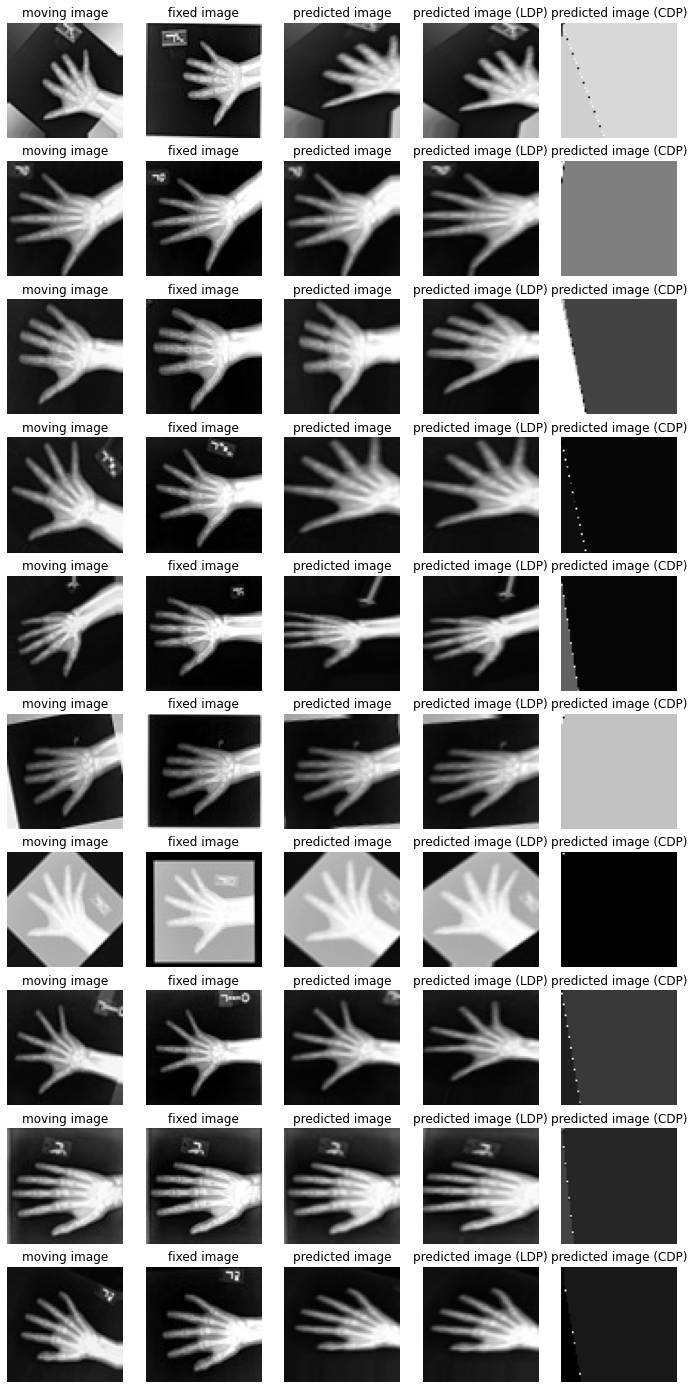

2022-05-13 15:36:04,536 fedbiomed INFO - CRITICAL
					 NODE node_f16ba230-4022-46b8-8438-84ba7a4b4890
					 MESSAGE: Node stopped in signal_handler, probably by user decision (Ctrl C)
-----------------------------------------------------------------
05/13/2022 15:36:04:INFO:CRITICAL
					 NODE node_f16ba230-4022-46b8-8438-84ba7a4b4890
					 MESSAGE: Node stopped in signal_handler, probably by user decision (Ctrl C)
-----------------------------------------------------------------


In [25]:
%matplotlib inline
batch_size = 10
plt.subplots(batch_size, 5, figsize=(12, 25))
for b in range(batch_size):
    # moving image
    plt.subplot(batch_size, 5, b * 5 + 1)
    plt.axis('off')
    plt.title("moving image")
    plt.imshow(moving_image[b], cmap="gray")
    # fixed image
    plt.subplot(batch_size, 5, b * 5 + 2)
    plt.axis('off')
    plt.title("fixed image")
    plt.imshow(fixed_image[b], cmap="gray")
    # warped moving
    plt.subplot(batch_size, 5, b * 5 + 3)
    plt.axis('off')
    plt.title("predicted image")
    plt.imshow(pred_image[b], cmap="gray")
    # warped moving LDP
    plt.subplot(batch_size, 5, b * 5 + 4)
    plt.axis('off')
    plt.title("predicted image (LDP)")
    plt.imshow(pred_image_LDP[b], cmap="gray")
    # warped moving CDP
    plt.subplot(batch_size, 5, b * 5 + 5)
    plt.axis('off')
    plt.title("predicted image (CDP)")
    plt.imshow(pred_image_CDP[b], cmap="gray")
plt.axis('off')
plt.show()